# INM707 Deep Learning: Optimization - Coursework #
##  Part 2b:Advanced - LunarLander using Duelling Deep Q Network with Experience Replay#
### Author - Abin Abraham ###
The task is to successfully land the lunar lander on the moon by training an training using Duelling Deep Q Network with Experience Replay. The environment is solved when the 100 episode average is greater than 200 points.

## Setting up code and experiment for number of neurons in hidden layer ##

In [14]:
#Code adapted from https://theaisummer.com/Taking_Deep_Q_Networks_a_step_further/ and INM707 Tutorial 6
#Importing required libraries for environment, data analysis and plotting
import gym
import random
import numpy as np
np.random.seed(0)
from collections import deque
import matplotlib.pyplot as plt

#Loading keras tensorflow libraries
from keras import Sequential,Model
from keras.layers import Dense,Input,Lambda,Add
from keras.optimizers import adam,RMSprop
from keras.activations import relu, linear
from keras.losses import huber_loss
from keras import backend as K


#Implmentation of Duelling DQN with exploration, experience replay
class DuellingDQN:
    def __init__(self,env, lr, gamma, epsilon, epsilon_decay, episodes,neurons):
        self.env = env
        self.action_space = env.action_space.n
        self.state_space = env.observation_space.shape[0]
        self.hidden1=neurons # Number of neurons per hidden layer is a hyperparameter
        self.hidden2= int(neurons/2) # We take half of the number of neurons from first layer
        self.epsilon = epsilon # exploration rate: how much to act randomly; more initially than later due to epsilon decay
        self.gamma = gamma # discount rate: enables agent to take into account future actions in addition to the immediate ones, but discounted at this rate
        self.batch_size = 64 # batch size for experience replay
        self.episodes=episodes;#Number of episodes to run agent
        self.epsilon_min = .01 # minimum exploration probability
        self.lr = lr # learning rate at which neural network adjusts models parameters
        self.epsilon_decay = epsilon_decay # rate of decay todecrease number of random explorations and increase greedy
        self.memory = deque(maxlen=100000) # double-ended queue; acts like list, but elements can be added/removed from either end
        self.model = self.build_model() #primary model which will be trained
        #self.target_model =  self.build_model() # target model, will not be trained
        #self.target_model.set_weights(self.model.get_weights()) #Copying intial weights of primary model to target model
        #self.train()

    #Creating the Duelling Deep Q network model
    def build_model(self):
        input_data = Input(shape=(self.state_space,))
        duel_model= input_data;
        duel_model= Dense(self.hidden1, input_dim=self.state_space, activation='elu',kernel_initializer='he_uniform')(duel_model) # 1st hidden layer; states as input
        duel_model= Dense(self.hidden2, activation='elu',kernel_initializer='he_uniform')(duel_model) # 2nd hidden layer
        
        #state value
        state_value = Dense(1, kernel_initializer='he_uniform',activation='elu')(duel_model)
        state_value = Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(self.action_space,))(state_value)
         
        #action advantage
        action_advantage = Dense(self.action_space, kernel_initializer='he_uniform',activation='elu')(duel_model)
        action_advantage = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(self.action_space,))(action_advantage)

        #combining the 2 streams
        duel_model = Add()([state_value, action_advantage])
        
        model = Model(inputs = input_data, outputs = duel_model)
        model.compile(loss='mse', optimizer=adam(lr=self.lr))
        
        return model

    def add_to_replaybuffer(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # Append S,A,R,NS, D to replay memory

    #Epsilon greedy policy for determining next action given current state
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space) #return random action
        act_values = self.model.predict(state)
        return np.argmax(act_values[0]) # pick the action that will give the highest reward 

    def experience_replay(self):
        if len(self.memory) < self.batch_size: #Wait till minimum size of replay memory
            return
        minibatch = random.sample(self.memory, self.batch_size) # sample a minibatch from memory
        states = np.array([i[0] for i in minibatch]) # extract data for each minibatch sample
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        # selection and evaluation of action using the duelling deep Q Network
        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        
        # predict Q-values for current state using the duelling deep Q Network
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets
        
        # train the primary network
        self.model.fit(states, targets_full, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:# Decay epsilon rate
            self.epsilon *= self.epsilon_decay

    #Update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    #Training the agent
    def train(self):
        episode_score = []
        episode_100mean_score=[]
        for e in range(self.episodes):
            state = self.env.reset()
            state = np.reshape(state, (1, 8))
            score = 0
            max_steps = 1000
            for i in range(max_steps):
                action = self.act(state)
                #env.render()
                next_state, reward, done, _ = self.env.step(action)
                score += reward
                next_state = np.reshape(next_state, (1, 8))
                self.add_to_replaybuffer(state, action, reward, next_state, done)
                state = next_state
                self.experience_replay()
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.episodes, score))
                    break
            episode_score.append(score)


            # Average score of last 100 episode
            is_solved = np.mean(episode_score[-100:])
            episode_100mean_score.append(is_solved)
            if is_solved > 200:
                print('\n Task Completed! \n')
                break
            print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
            self.update_epsilon();
        return episode_100mean_score


if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    env.seed(0)
    np.random.seed(0)
    agent1 = DuellingDQN(env, .001, .98, 1, .8, 1000, 128)
    agent1_trial_score=agent1.train()

episode: 0/1000, score: -278.73082418137864
Average over last 100 episode: -278.73 

episode: 1/1000, score: -302.0457431301911
Average over last 100 episode: -290.39 

episode: 2/1000, score: -253.557059748117
Average over last 100 episode: -278.11 

episode: 3/1000, score: 11.609726301888827
Average over last 100 episode: -205.68 

episode: 4/1000, score: -162.41094426163843
Average over last 100 episode: -197.03 

episode: 5/1000, score: -197.94034805920973
Average over last 100 episode: -197.18 

episode: 6/1000, score: -354.2646691274127
Average over last 100 episode: -219.62 

episode: 7/1000, score: -276.0126497913942
Average over last 100 episode: -226.67 

episode: 8/1000, score: -169.20574572946092
Average over last 100 episode: -220.28 

episode: 9/1000, score: -86.35370782213252
Average over last 100 episode: -206.89 

episode: 10/1000, score: -154.58889032082283
Average over last 100 episode: -202.14 

episode: 11/1000, score: -195.34793272137193
Average over last 100 epis

episode: 97/1000, score: -28.099531891415353
Average over last 100 episode: -81.23 

episode: 98/1000, score: 0.022569050135103907
Average over last 100 episode: -80.41 

episode: 99/1000, score: -81.11213868641838
Average over last 100 episode: -80.42 

episode: 100/1000, score: -159.0742364691188
Average over last 100 episode: -79.22 

episode: 101/1000, score: -131.75385553787186
Average over last 100 episode: -77.52 

episode: 102/1000, score: -21.57740343745408
Average over last 100 episode: -75.20 

episode: 103/1000, score: -280.7894917559113
Average over last 100 episode: -78.13 

episode: 104/1000, score: -51.85581327265163
Average over last 100 episode: -77.02 

episode: 105/1000, score: -25.590175794430696
Average over last 100 episode: -75.30 

episode: 106/1000, score: -189.08902371509438
Average over last 100 episode: -73.64 

episode: 107/1000, score: -38.851537961055115
Average over last 100 episode: -71.27 

episode: 108/1000, score: 83.22788250809364
Average over last

episode: 195/1000, score: 36.9971310437887
Average over last 100 episode: 72.31 

episode: 196/1000, score: 5.579498966474759
Average over last 100 episode: 70.51 

episode: 197/1000, score: 134.06077017318944
Average over last 100 episode: 72.13 

episode: 198/1000, score: 162.07730684638813
Average over last 100 episode: 73.75 

episode: 199/1000, score: 254.1485077401567
Average over last 100 episode: 77.10 

episode: 200/1000, score: 249.5951077362774
Average over last 100 episode: 81.19 

episode: 201/1000, score: 170.09812848778833
Average over last 100 episode: 84.21 

episode: 202/1000, score: 217.33769738112738
Average over last 100 episode: 86.60 

episode: 203/1000, score: 166.30059505965707
Average over last 100 episode: 91.07 

episode: 204/1000, score: 208.71335739975723
Average over last 100 episode: 93.68 

episode: 205/1000, score: 250.8553516405262
Average over last 100 episode: 96.44 

episode: 206/1000, score: 240.42547734561413
Average over last 100 episode: 100.73

episode: 292/1000, score: 177.41628864190187
Average over last 100 episode: 174.48 

episode: 293/1000, score: 292.83321879082246
Average over last 100 episode: 175.69 

episode: 294/1000, score: 24.0234976741624
Average over last 100 episode: 173.70 

episode: 295/1000, score: 260.56344402371747
Average over last 100 episode: 175.94 

episode: 296/1000, score: 219.1982444897591
Average over last 100 episode: 178.07 

episode: 297/1000, score: 206.8727911190623
Average over last 100 episode: 178.80 

episode: 298/1000, score: -49.04793964671288
Average over last 100 episode: 176.69 

episode: 299/1000, score: 233.86583059583683
Average over last 100 episode: 176.49 

episode: 300/1000, score: 196.69216658681464
Average over last 100 episode: 175.96 

episode: 301/1000, score: 221.2825311950755
Average over last 100 episode: 176.47 

episode: 302/1000, score: 238.5279257778702
Average over last 100 episode: 176.68 

episode: 303/1000, score: 233.11997319081556
Average over last 100 epis

### No. of Neurons Experiment 2 - lr=0.001, gamma=0.98, epsilon=1, epsilon_decay=0.8, episodes=1000, no. of neurons in hidden layer 256 ###

In [5]:
agent2 = DuellingDQN(env, .001, .98, 1, .8, 1000, 256)
agent2_trial_score=agent2.train()

episode: 0/1000, score: -13.748015864707824
Average over last 100 episode: -13.75 

episode: 1/1000, score: -206.13255868677118
Average over last 100 episode: -109.94 

episode: 2/1000, score: -126.48729117655661
Average over last 100 episode: -115.46 

episode: 3/1000, score: -315.69439885207976
Average over last 100 episode: -165.52 

episode: 4/1000, score: -162.82746792249196
Average over last 100 episode: -164.98 

episode: 5/1000, score: -470.9338525909036
Average over last 100 episode: -215.97 

episode: 6/1000, score: -232.95100421752704
Average over last 100 episode: -218.40 

episode: 7/1000, score: -111.52585212584782
Average over last 100 episode: -205.04 

episode: 8/1000, score: -323.99757250532474
Average over last 100 episode: -218.26 

episode: 9/1000, score: -266.7594107419976
Average over last 100 episode: -223.11 

episode: 10/1000, score: -168.86736137709943
Average over last 100 episode: -218.17 

episode: 11/1000, score: -153.59606904139233
Average over last 100 

episode: 97/1000, score: -95.24445367560175
Average over last 100 episode: -109.22 

episode: 98/1000, score: -18.569462833917697
Average over last 100 episode: -108.31 

episode: 99/1000, score: 119.8357589025271
Average over last 100 episode: -106.02 

episode: 100/1000, score: -255.76757348288854
Average over last 100 episode: -108.45 

episode: 101/1000, score: 197.19610471336796
Average over last 100 episode: -104.41 

episode: 102/1000, score: -33.15808066126007
Average over last 100 episode: -103.48 

episode: 103/1000, score: -65.45582980568255
Average over last 100 episode: -100.98 

episode: 104/1000, score: -775.4513756027812
Average over last 100 episode: -107.10 

episode: 105/1000, score: -137.85255232068278
Average over last 100 episode: -103.77 

episode: 106/1000, score: 26.47169533112573
Average over last 100 episode: -101.18 

episode: 107/1000, score: 245.99912372685745
Average over last 100 episode: -97.60 

episode: 108/1000, score: -136.1971963121511
Average over

episode: 194/1000, score: 240.0087394951581
Average over last 100 episode: 117.49 

episode: 195/1000, score: 189.73136219563918
Average over last 100 episode: 117.90 

episode: 196/1000, score: 30.750511590306814
Average over last 100 episode: 115.60 

episode: 197/1000, score: 132.37784593564294
Average over last 100 episode: 117.88 

episode: 198/1000, score: 273.6067149214316
Average over last 100 episode: 120.80 

episode: 199/1000, score: 195.95132723763948
Average over last 100 episode: 121.56 

episode: 200/1000, score: -20.514010618917453
Average over last 100 episode: 123.91 

episode: 201/1000, score: 288.79792117699384
Average over last 100 episode: 124.83 

episode: 202/1000, score: 240.51359763289645
Average over last 100 episode: 127.56 

episode: 203/1000, score: 284.7411333799006
Average over last 100 episode: 131.07 

episode: 204/1000, score: 236.7431006402178
Average over last 100 episode: 141.19 

episode: 205/1000, score: 219.5953441602938
Average over last 100 ep

### No. of Neurons Experiment 3 - lr=0.001, gamma=0.98, epsilon=1, epsilon_decay=0.8, episodes=1000, no. of neurons in hidden layer 512###

In [15]:
agent3 = DuellingDQN(env, .001, .98, 1, 0.8, 1000,512)
agent3_trial_score=agent3.train()

episode: 0/1000, score: -282.6475564304982
Average over last 100 episode: -282.65 

episode: 1/1000, score: -204.01757995892473
Average over last 100 episode: -243.33 

episode: 2/1000, score: -423.8956409833103
Average over last 100 episode: -303.52 

episode: 3/1000, score: -540.0329488362594
Average over last 100 episode: -362.65 

episode: 4/1000, score: -125.0651617447542
Average over last 100 episode: -315.13 

episode: 5/1000, score: 8.997722430188588
Average over last 100 episode: -261.11 

episode: 6/1000, score: -269.10576182482237
Average over last 100 episode: -262.25 

episode: 7/1000, score: -268.1897301829013
Average over last 100 episode: -262.99 

episode: 8/1000, score: -120.10380282704415
Average over last 100 episode: -247.12 

episode: 9/1000, score: -79.15345871023635
Average over last 100 episode: -230.32 

episode: 10/1000, score: -18.30921820889074
Average over last 100 episode: -211.05 

episode: 11/1000, score: -393.7025669206987
Average over last 100 episode

episode: 97/1000, score: -280.71596291031153
Average over last 100 episode: -134.11 

episode: 98/1000, score: 21.656764574237414
Average over last 100 episode: -132.53 

episode: 99/1000, score: -7.449522703947636
Average over last 100 episode: -131.28 

episode: 100/1000, score: -88.62933940686656
Average over last 100 episode: -129.34 

episode: 101/1000, score: 206.44121118295433
Average over last 100 episode: -125.24 

episode: 102/1000, score: 227.83193264473445
Average over last 100 episode: -118.72 

episode: 103/1000, score: 275.19709286477996
Average over last 100 episode: -110.57 

episode: 104/1000, score: -19.557692002455255
Average over last 100 episode: -109.51 

episode: 105/1000, score: 261.4683386663189
Average over last 100 episode: -106.99 

episode: 106/1000, score: 169.6270628420992
Average over last 100 episode: -102.60 

episode: 107/1000, score: 109.47100969775096
Average over last 100 episode: -98.83 

episode: 108/1000, score: -164.6992688933745
Average over 

episode: 194/1000, score: 65.20386047000574
Average over last 100 episode: -0.04 

episode: 195/1000, score: -44.18602616800072
Average over last 100 episode: -0.83 

episode: 196/1000, score: 279.192306010945
Average over last 100 episode: 2.52 

episode: 197/1000, score: 213.62092198791078
Average over last 100 episode: 7.46 

episode: 198/1000, score: -113.62848065279917
Average over last 100 episode: 6.11 

episode: 199/1000, score: -210.9751565028178
Average over last 100 episode: 4.08 

episode: 200/1000, score: -75.74573260240359
Average over last 100 episode: 4.21 

episode: 201/1000, score: 17.393049192137696
Average over last 100 episode: 2.31 

episode: 202/1000, score: -294.3243869048507
Average over last 100 episode: -2.91 

episode: 203/1000, score: -42.757267399606135
Average over last 100 episode: -6.09 

episode: 204/1000, score: 97.49557102616411
Average over last 100 episode: -4.92 

episode: 205/1000, score: -106.31359190273176
Average over last 100 episode: -8.59 


episode: 291/1000, score: -339.30108744657423
Average over last 100 episode: 6.23 

episode: 292/1000, score: -349.30282805859116
Average over last 100 episode: 4.13 

episode: 293/1000, score: -94.40353079749049
Average over last 100 episode: 5.66 

episode: 294/1000, score: -217.50286974933957
Average over last 100 episode: 2.83 

episode: 295/1000, score: 199.03085986786022
Average over last 100 episode: 5.27 

episode: 296/1000, score: -181.46266746131238
Average over last 100 episode: 0.66 

episode: 297/1000, score: 23.077776892167947
Average over last 100 episode: -1.25 

episode: 298/1000, score: -59.02432372833637
Average over last 100 episode: -0.70 

episode: 299/1000, score: -19.72311260818816
Average over last 100 episode: 1.21 

episode: 300/1000, score: -52.278093089759615
Average over last 100 episode: 1.45 

episode: 301/1000, score: -32.8297104365097
Average over last 100 episode: 0.95 

episode: 302/1000, score: -220.20379616028504
Average over last 100 episode: 1.69

episode: 389/1000, score: -60.14315196616607
Average over last 100 episode: 10.60 

episode: 390/1000, score: 239.20961263672808
Average over last 100 episode: 10.53 

episode: 391/1000, score: -167.62634002001022
Average over last 100 episode: 12.25 

episode: 392/1000, score: -5.011248359641627
Average over last 100 episode: 15.69 

episode: 393/1000, score: -58.417281242230615
Average over last 100 episode: 16.05 

episode: 394/1000, score: -153.3910753365937
Average over last 100 episode: 16.69 

episode: 395/1000, score: -179.5511004313327
Average over last 100 episode: 12.91 

episode: 396/1000, score: -97.84027833559104
Average over last 100 episode: 13.74 

episode: 397/1000, score: -42.51883010592161
Average over last 100 episode: 13.09 

episode: 398/1000, score: -60.36569784530376
Average over last 100 episode: 13.07 

episode: 399/1000, score: -259.05425557893045
Average over last 100 episode: 10.68 

episode: 400/1000, score: -262.7909965615961
Average over last 100 episod

episode: 486/1000, score: 222.7151855071652
Average over last 100 episode: -23.20 

episode: 487/1000, score: -206.00218478763452
Average over last 100 episode: -27.51 

episode: 488/1000, score: -93.24685732511028
Average over last 100 episode: -30.68 

episode: 489/1000, score: -22.2181963245756
Average over last 100 episode: -30.30 

episode: 490/1000, score: -142.05802235587575
Average over last 100 episode: -34.11 

episode: 491/1000, score: -151.90894661849654
Average over last 100 episode: -33.96 

episode: 492/1000, score: -150.49963857499142
Average over last 100 episode: -35.41 

episode: 493/1000, score: -113.97417271577125
Average over last 100 episode: -35.97 

episode: 494/1000, score: -207.61219066619535
Average over last 100 episode: -36.51 

episode: 495/1000, score: 29.785962825181173
Average over last 100 episode: -34.42 

episode: 496/1000, score: -283.30928484404126
Average over last 100 episode: -36.27 

episode: 497/1000, score: -155.98379468135596
Average over l

episode: 583/1000, score: 16.96296235477685
Average over last 100 episode: -94.16 

episode: 584/1000, score: -44.140789077847465
Average over last 100 episode: -95.77 

episode: 585/1000, score: -35.55509401052653
Average over last 100 episode: -94.33 

episode: 586/1000, score: 260.1906941308166
Average over last 100 episode: -93.96 

episode: 587/1000, score: 198.4896768110795
Average over last 100 episode: -89.91 

episode: 588/1000, score: -224.0782632182474
Average over last 100 episode: -91.22 

episode: 589/1000, score: -250.64832991427974
Average over last 100 episode: -93.51 

episode: 590/1000, score: 27.308783499228937
Average over last 100 episode: -91.81 

episode: 591/1000, score: 203.46556788627794
Average over last 100 episode: -88.26 

episode: 592/1000, score: 205.79578632824447
Average over last 100 episode: -84.70 

episode: 593/1000, score: -350.35647691311124
Average over last 100 episode: -87.06 

episode: 594/1000, score: 255.61041938096886
Average over last 10

episode: 680/1000, score: 230.95666371184464
Average over last 100 episode: 0.88 

episode: 681/1000, score: 114.70458068801466
Average over last 100 episode: 2.73 

episode: 682/1000, score: 4.25424280121679
Average over last 100 episode: 4.08 

episode: 683/1000, score: -255.16176408640615
Average over last 100 episode: 1.36 

episode: 684/1000, score: 220.3970234947463
Average over last 100 episode: 4.01 

episode: 685/1000, score: 66.89182578463995
Average over last 100 episode: 5.03 

episode: 686/1000, score: -32.20991765451497
Average over last 100 episode: 2.11 

episode: 687/1000, score: 33.589995574897785
Average over last 100 episode: 0.46 

episode: 688/1000, score: -113.65934433380883
Average over last 100 episode: 1.56 

episode: 689/1000, score: 165.74677348733954
Average over last 100 episode: 5.73 

episode: 690/1000, score: 172.83020757481273
Average over last 100 episode: 7.18 

episode: 691/1000, score: 219.45892848315532
Average over last 100 episode: 7.34 

episod

episode: 778/1000, score: -86.1588210584707
Average over last 100 episode: -54.38 

episode: 779/1000, score: 221.25529607545607
Average over last 100 episode: -54.42 

episode: 780/1000, score: -14.739438595838251
Average over last 100 episode: -56.87 

episode: 781/1000, score: -121.68746840115473
Average over last 100 episode: -59.24 

episode: 782/1000, score: 4.394450419688013
Average over last 100 episode: -59.24 

episode: 783/1000, score: 270.1151751344934
Average over last 100 episode: -53.98 

episode: 784/1000, score: 210.97026238719656
Average over last 100 episode: -54.08 

episode: 785/1000, score: -192.4242812778144
Average over last 100 episode: -56.67 

episode: 786/1000, score: -36.839489677660154
Average over last 100 episode: -56.72 

episode: 787/1000, score: -138.40341749744906
Average over last 100 episode: -58.44 

episode: 788/1000, score: -113.4401590273361
Average over last 100 episode: -58.43 

episode: 789/1000, score: -100.9175500162382
Average over last 1

episode: 875/1000, score: 261.7762982316194
Average over last 100 episode: 39.25 

episode: 876/1000, score: 304.1362462127097
Average over last 100 episode: 39.99 

episode: 877/1000, score: -243.34895396233577
Average over last 100 episode: 35.43 

episode: 878/1000, score: 273.10683151970534
Average over last 100 episode: 39.02 

episode: 879/1000, score: -360.9618342830471
Average over last 100 episode: 33.20 

episode: 880/1000, score: -178.60088870473118
Average over last 100 episode: 31.56 

episode: 881/1000, score: 298.9830656560663
Average over last 100 episode: 35.77 

episode: 882/1000, score: -117.3098481363519
Average over last 100 episode: 34.55 

episode: 883/1000, score: 20.6401226516589
Average over last 100 episode: 32.06 

episode: 884/1000, score: 81.28873845815178
Average over last 100 episode: 30.76 

episode: 885/1000, score: -132.6336702080946
Average over last 100 episode: 31.36 

episode: 886/1000, score: -22.904518777188315
Average over last 100 episode: 31.

episode: 973/1000, score: -82.00085742623756
Average over last 100 episode: -19.67 

episode: 974/1000, score: -405.87892099053676
Average over last 100 episode: -23.32 

episode: 975/1000, score: 33.211313055430594
Average over last 100 episode: -25.61 

episode: 976/1000, score: -203.36361969340555
Average over last 100 episode: -30.68 

episode: 977/1000, score: 190.40649572751389
Average over last 100 episode: -26.35 

episode: 978/1000, score: -170.24216268431155
Average over last 100 episode: -30.78 

episode: 979/1000, score: -220.07794232131323
Average over last 100 episode: -29.37 

episode: 980/1000, score: 229.66571309989374
Average over last 100 episode: -25.29 

episode: 981/1000, score: -212.52351887632526
Average over last 100 episode: -30.40 

episode: 982/1000, score: 37.30408956591117
Average over last 100 episode: -28.86 

episode: 983/1000, score: 226.80691371233243
Average over last 100 episode: -26.80 

episode: 984/1000, score: 20.085145616472772
Average over las

### Plotting 100 Episode Moving Average Rewards for different Number of Neurons in Hidden Layer ###

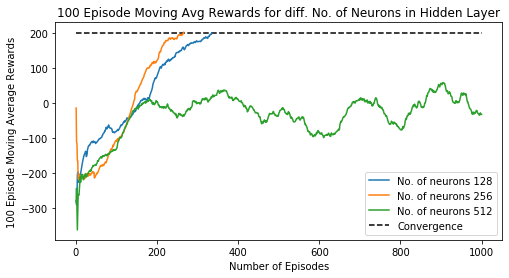

In [25]:
fig= plt.figure(figsize=(8,4))
plt.title('100 Episode Moving Avg Rewards for diff. No. of Neurons in Hidden Layer')
plt.plot([i+1 for i in range(0, len(agent1_trial_score))],agent1_trial_score,label='No. of neurons 128',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent2_trial_score))],agent2_trial_score,label='No. of neurons 256',alpha=1  )
plt.plot([i+1 for i in range(0, len(agent3_trial_score))],agent3_trial_score,label='No. of neurons 512',alpha=1 )
plt.hlines(200, 0, 1000,colors='k',linestyles='--',label='Convergence')
plt.legend(loc='lower right')
plt.xlabel("Number of Episodes")
plt.ylabel("100 Episode Moving Average Rewards")
plt.show()

## Experiment for learning rate ##

### Learning Rate Experiment 1 - lr=0.005, gamma=0.98, epsilon=1, epsilon_decay=0.8, episodes=1000 ###

In [19]:
agent1_lr = DuellingDQN(env, .005, .98, 1, .8, 1000, 256)
agent1_lr_trial_score=agent1_lr.train()

episode: 0/1000, score: -211.4724864396976
Average over last 100 episode: -211.47 

episode: 1/1000, score: -371.5980948102599
Average over last 100 episode: -291.54 

episode: 2/1000, score: -80.91137988285283
Average over last 100 episode: -221.33 

episode: 3/1000, score: -137.82728265750978
Average over last 100 episode: -200.45 

episode: 4/1000, score: -91.83389733439942
Average over last 100 episode: -178.73 

episode: 5/1000, score: -166.30279757667347
Average over last 100 episode: -176.66 

episode: 6/1000, score: -280.15118773360496
Average over last 100 episode: -191.44 

episode: 7/1000, score: -218.60054927379855
Average over last 100 episode: -194.84 

episode: 8/1000, score: -296.3688604855097
Average over last 100 episode: -206.12 

episode: 9/1000, score: -113.52565368373017
Average over last 100 episode: -196.86 

episode: 10/1000, score: -293.7561663955999
Average over last 100 episode: -205.67 

episode: 11/1000, score: -258.5920906898875
Average over last 100 epis

episode: 97/1000, score: -230.20254859809432
Average over last 100 episode: -186.08 

episode: 98/1000, score: -260.2374042410393
Average over last 100 episode: -186.83 

episode: 99/1000, score: -266.1604177866285
Average over last 100 episode: -187.62 

episode: 100/1000, score: -202.5783885326286
Average over last 100 episode: -187.53 

episode: 101/1000, score: -190.0826954180077
Average over last 100 episode: -185.72 

episode: 102/1000, score: -176.22174651469638
Average over last 100 episode: -186.67 

episode: 103/1000, score: -157.59124446482872
Average over last 100 episode: -186.87 

episode: 104/1000, score: 3.085555122188552
Average over last 100 episode: -185.92 

episode: 105/1000, score: -311.981217959294
Average over last 100 episode: -187.38 

episode: 106/1000, score: -395.9952905487939
Average over last 100 episode: -188.54 

episode: 107/1000, score: -254.22299188027068
Average over last 100 episode: -188.89 

episode: 108/1000, score: -295.36534544133247
Average o

episode: 192/1000, score: -323.86622201512034
Average over last 100 episode: -315.46 

episode: 193/1000, score: -265.9079801284312
Average over last 100 episode: -314.70 

episode: 194/1000, score: -183.0626725464463
Average over last 100 episode: -312.59 

episode: 195/1000, score: -592.7620395639374
Average over last 100 episode: -313.10 

episode: 196/1000, score: -193.56147631564426
Average over last 100 episode: -313.25 

episode: 197/1000, score: -614.2288286674248
Average over last 100 episode: -317.09 

episode: 198/1000, score: -442.9413508907384
Average over last 100 episode: -318.92 

episode: 199/1000, score: -326.30211090118223
Average over last 100 episode: -319.52 

episode: 200/1000, score: -329.466683534402
Average over last 100 episode: -320.79 

episode: 201/1000, score: -371.2404168321582
Average over last 100 episode: -322.60 

episode: 202/1000, score: -258.47830855459307
Average over last 100 episode: -323.43 

episode: 203/1000, score: -263.76368336254626
Avera

episode: 287/1000, score: -297.8584579630339
Average over last 100 episode: -349.24 

episode: 288/1000, score: -541.4174081704168
Average over last 100 episode: -349.52 

episode: 289/1000, score: -210.53447468685752
Average over last 100 episode: -349.06 

episode: 290/1000, score: -86.21494367028082
Average over last 100 episode: -343.16 

episode: 291/1000, score: -199.14195454078816
Average over last 100 episode: -341.84 

episode: 292/1000, score: -340.79670932579756
Average over last 100 episode: -342.01 

episode: 293/1000, score: -654.5939304262845
Average over last 100 episode: -345.90 

episode: 294/1000, score: -295.0142163142927
Average over last 100 episode: -347.01 

episode: 295/1000, score: -980.8878293874449
Average over last 100 episode: -350.90 

episode: 296/1000, score: -357.56564324931895
Average over last 100 episode: -352.54 

episode: 297/1000, score: -265.96768239253856
Average over last 100 episode: -349.05 

episode: 298/1000, score: 13.569639211105368
Aver

episode: 382/1000, score: -371.73942417185486
Average over last 100 episode: -335.91 

episode: 383/1000, score: -283.6576810841178
Average over last 100 episode: -336.83 

episode: 384/1000, score: -410.33845108340137
Average over last 100 episode: -340.00 

episode: 385/1000, score: -228.0996682335268
Average over last 100 episode: -338.23 

episode: 386/1000, score: -156.5826138034388
Average over last 100 episode: -334.30 

episode: 387/1000, score: -162.35441587768278
Average over last 100 episode: -332.95 

episode: 388/1000, score: -326.42229642914356
Average over last 100 episode: -330.80 

episode: 389/1000, score: -155.3847625180141
Average over last 100 episode: -330.24 

episode: 390/1000, score: -768.6480869501607
Average over last 100 episode: -337.07 

episode: 391/1000, score: -288.0297416543367
Average over last 100 episode: -337.96 

episode: 392/1000, score: -237.7459657260115
Average over last 100 episode: -336.93 

episode: 393/1000, score: -453.40886401298286
Aver

episode: 477/1000, score: -569.4041376885793
Average over last 100 episode: -306.89 

episode: 478/1000, score: -330.0427853426985
Average over last 100 episode: -305.02 

episode: 479/1000, score: -192.09374193246686
Average over last 100 episode: -302.61 

episode: 480/1000, score: -223.80991177690345
Average over last 100 episode: -302.64 

episode: 481/1000, score: -42.81145124640112
Average over last 100 episode: -299.60 

episode: 482/1000, score: -290.91863219551044
Average over last 100 episode: -298.79 

episode: 483/1000, score: -44.300332039294815
Average over last 100 episode: -296.40 

episode: 484/1000, score: -123.24757010818178
Average over last 100 episode: -293.53 

episode: 485/1000, score: -162.25367513309754
Average over last 100 episode: -292.87 

episode: 486/1000, score: -176.20100411104295
Average over last 100 episode: -293.06 

episode: 487/1000, score: 4.38720802301097
Average over last 100 episode: -291.40 

episode: 488/1000, score: -242.34545724588438
Ave

episode: 572/1000, score: -219.0520235895703
Average over last 100 episode: -287.54 

episode: 573/1000, score: -255.95554798338267
Average over last 100 episode: -287.18 

episode: 574/1000, score: -281.8576297981442
Average over last 100 episode: -285.07 

episode: 575/1000, score: -144.328671819279
Average over last 100 episode: -275.10 

episode: 576/1000, score: -187.0943851326685
Average over last 100 episode: -261.16 

episode: 577/1000, score: -92.75922135868807
Average over last 100 episode: -256.39 

episode: 578/1000, score: -236.44541806992945
Average over last 100 episode: -255.46 

episode: 579/1000, score: -111.84082926689182
Average over last 100 episode: -254.66 

episode: 580/1000, score: -376.7209344200236
Average over last 100 episode: -256.19 

episode: 581/1000, score: -201.76164968845052
Average over last 100 episode: -257.77 

episode: 582/1000, score: -384.7886958474595
Average over last 100 episode: -258.71 

episode: 583/1000, score: -247.5634856365002
Averag

episode: 667/1000, score: -204.5777816858494
Average over last 100 episode: -208.92 

episode: 668/1000, score: -130.7409195097585
Average over last 100 episode: -208.24 

episode: 669/1000, score: -216.0272988812784
Average over last 100 episode: -207.98 

episode: 670/1000, score: -75.55349851698297
Average over last 100 episode: -207.79 

episode: 671/1000, score: -91.60906381738207
Average over last 100 episode: -208.14 

episode: 672/1000, score: -113.93497569877815
Average over last 100 episode: -207.08 

episode: 673/1000, score: -146.0723683971269
Average over last 100 episode: -205.99 

episode: 674/1000, score: -11.641171823068532
Average over last 100 episode: -203.28 

episode: 675/1000, score: -167.92236378666252
Average over last 100 episode: -203.52 

episode: 676/1000, score: -254.13066612083912
Average over last 100 episode: -204.19 

episode: 677/1000, score: -146.8504852697699
Average over last 100 episode: -204.73 

episode: 678/1000, score: -97.50821723916184
Avera

episode: 762/1000, score: -471.0079718937169
Average over last 100 episode: -177.18 

episode: 763/1000, score: -327.6491328176853
Average over last 100 episode: -179.41 

episode: 764/1000, score: -160.92974169786712
Average over last 100 episode: -181.15 

episode: 765/1000, score: -441.6483629945356
Average over last 100 episode: -185.17 

episode: 766/1000, score: -277.22258949202046
Average over last 100 episode: -186.14 

episode: 767/1000, score: -85.67229827665184
Average over last 100 episode: -184.95 

episode: 768/1000, score: -321.1628438429956
Average over last 100 episode: -186.86 

episode: 769/1000, score: -338.0919656160522
Average over last 100 episode: -188.08 

episode: 770/1000, score: -405.80933788685047
Average over last 100 episode: -191.38 

episode: 771/1000, score: -191.07772766726737
Average over last 100 episode: -192.38 

episode: 772/1000, score: -311.1330504615109
Average over last 100 episode: -194.35 

episode: 773/1000, score: -262.5775142413387
Avera

episode: 857/1000, score: -146.8612047893746
Average over last 100 episode: -304.88 

episode: 858/1000, score: -215.09783637568484
Average over last 100 episode: -303.28 

episode: 859/1000, score: -104.20390836299447
Average over last 100 episode: -300.87 

episode: 860/1000, score: -84.90891025260719
Average over last 100 episode: -299.29 

episode: 861/1000, score: -155.98713226900855
Average over last 100 episode: -293.72 

episode: 862/1000, score: 7.453451295245088
Average over last 100 episode: -288.94 

episode: 863/1000, score: -104.92205558965398
Average over last 100 episode: -286.71 

episode: 864/1000, score: -27.34729376928324
Average over last 100 episode: -285.38 

episode: 865/1000, score: -80.7022220506839
Average over last 100 episode: -281.77 

episode: 866/1000, score: -213.75113486958344
Average over last 100 episode: -281.13 

episode: 867/1000, score: -135.8415881556738
Average over last 100 episode: -281.63 

episode: 868/1000, score: -197.28689053826812
Avera

episode: 952/1000, score: -306.6569459980753
Average over last 100 episode: -196.38 

episode: 953/1000, score: -261.69395057797556
Average over last 100 episode: -194.96 

episode: 954/1000, score: -195.6305889494525
Average over last 100 episode: -197.14 

episode: 955/1000, score: -173.10493640525564
Average over last 100 episode: -198.29 

episode: 956/1000, score: -127.43944623492877
Average over last 100 episode: -198.86 

episode: 957/1000, score: -132.45786457685497
Average over last 100 episode: -198.72 

episode: 958/1000, score: -119.94169080397303
Average over last 100 episode: -197.77 

episode: 959/1000, score: -203.48870062854132
Average over last 100 episode: -198.76 

episode: 960/1000, score: -183.74367545656102
Average over last 100 episode: -199.75 

episode: 961/1000, score: -183.95708974351155
Average over last 100 episode: -200.03 

episode: 962/1000, score: -267.1919020533471
Average over last 100 episode: -202.77 

episode: 963/1000, score: -136.93333782666195


### Learning Rate Experiment 2 - lr=0.0005, gamma=0.98, epsilon=1, epsilon_decay=0.8, episodes=1000 ###

In [21]:
agent2_lr = DuellingDQN(env, .0005, .98, 1, .8, 1000,256)
agent2_lr_trial_score=agent2_lr.train()

episode: 0/1000, score: -68.82237642389194
Average over last 100 episode: -68.82 

episode: 1/1000, score: -269.94954777515795
Average over last 100 episode: -169.39 

episode: 2/1000, score: -342.7574800940547
Average over last 100 episode: -227.18 

episode: 3/1000, score: -133.00590694929508
Average over last 100 episode: -203.63 

episode: 4/1000, score: -161.12848272850448
Average over last 100 episode: -195.13 

episode: 5/1000, score: -302.8945113816558
Average over last 100 episode: -213.09 

episode: 6/1000, score: -263.18360193738533
Average over last 100 episode: -220.25 

episode: 7/1000, score: -231.53947573508458
Average over last 100 episode: -221.66 

episode: 8/1000, score: -442.4461402849291
Average over last 100 episode: -246.19 

episode: 9/1000, score: -236.7625810502822
Average over last 100 episode: -245.25 

episode: 10/1000, score: -265.49481524573844
Average over last 100 episode: -247.09 

episode: 11/1000, score: -214.61750410531133
Average over last 100 epi

episode: 97/1000, score: -151.07727081466334
Average over last 100 episode: -95.48 

episode: 98/1000, score: -126.30534470242077
Average over last 100 episode: -95.79 

episode: 99/1000, score: -306.8583385650569
Average over last 100 episode: -97.90 

episode: 100/1000, score: -281.3340255751932
Average over last 100 episode: -100.03 

episode: 101/1000, score: -78.9225480876409
Average over last 100 episode: -98.12 

episode: 102/1000, score: 12.748714899129238
Average over last 100 episode: -94.56 

episode: 103/1000, score: -19.57006411023295
Average over last 100 episode: -93.43 

episode: 104/1000, score: -191.67623156780638
Average over last 100 episode: -93.74 

episode: 105/1000, score: -49.61969548889188
Average over last 100 episode: -91.20 

episode: 106/1000, score: -90.42194371045225
Average over last 100 episode: -89.48 

episode: 107/1000, score: -93.22017327525138
Average over last 100 episode: -88.09 

episode: 108/1000, score: -94.24703370268895
Average over last 10

episode: 194/1000, score: 251.2073731228812
Average over last 100 episode: 15.89 

episode: 195/1000, score: -20.252940672685725
Average over last 100 episode: 16.30 

episode: 196/1000, score: 185.22807656642271
Average over last 100 episode: 20.23 

episode: 197/1000, score: -85.35185797563207
Average over last 100 episode: 20.89 

episode: 198/1000, score: 207.49407895068617
Average over last 100 episode: 24.22 

episode: 199/1000, score: -149.075119730249
Average over last 100 episode: 25.80 

episode: 200/1000, score: -207.36290767273502
Average over last 100 episode: 26.54 

episode: 201/1000, score: 245.57419453788512
Average over last 100 episode: 29.79 

episode: 202/1000, score: 221.96127465017017
Average over last 100 episode: 31.88 

episode: 203/1000, score: 260.3873534981185
Average over last 100 episode: 34.68 

episode: 204/1000, score: 264.06800687075963
Average over last 100 episode: 39.24 

episode: 205/1000, score: 251.97925833574513
Average over last 100 episode: 4

episode: 292/1000, score: 245.28681156719406
Average over last 100 episode: 149.80 

episode: 293/1000, score: 206.92945765090417
Average over last 100 episode: 149.71 

episode: 294/1000, score: 192.3152416118959
Average over last 100 episode: 149.12 

episode: 295/1000, score: 198.88379143626128
Average over last 100 episode: 151.31 

episode: 296/1000, score: 264.97926602943676
Average over last 100 episode: 152.11 

episode: 297/1000, score: 227.72896977993514
Average over last 100 episode: 155.24 

episode: 298/1000, score: 229.37532131532384
Average over last 100 episode: 155.46 

episode: 299/1000, score: 254.23490282872652
Average over last 100 episode: 159.49 

episode: 300/1000, score: 240.91720016661657
Average over last 100 episode: 163.98 

episode: 301/1000, score: 145.6049916317008
Average over last 100 episode: 162.98 

episode: 302/1000, score: 249.23031216848162
Average over last 100 episode: 163.25 

episode: 303/1000, score: 279.465930781706
Average over last 100 ep

episode: 389/1000, score: 234.7537172743474
Average over last 100 episode: 183.46 

episode: 390/1000, score: 258.00230198895497
Average over last 100 episode: 185.89 

episode: 391/1000, score: 281.9704412623675
Average over last 100 episode: 185.73 

episode: 392/1000, score: 196.18536057176334
Average over last 100 episode: 185.24 

episode: 393/1000, score: 188.1532472425475
Average over last 100 episode: 185.05 

episode: 394/1000, score: 302.3229396553654
Average over last 100 episode: 186.15 

episode: 395/1000, score: 225.42260387303588
Average over last 100 episode: 186.42 

episode: 396/1000, score: -45.816706326223496
Average over last 100 episode: 183.31 

episode: 397/1000, score: 240.9691127500978
Average over last 100 episode: 183.44 

episode: 398/1000, score: 267.2227096855636
Average over last 100 episode: 183.82 

episode: 399/1000, score: 269.54213964071096
Average over last 100 episode: 183.98 

episode: 400/1000, score: 243.16517110535165
Average over last 100 epi

### Plotting 100 Episode Moving Average Rewards for different Learning Rate ###

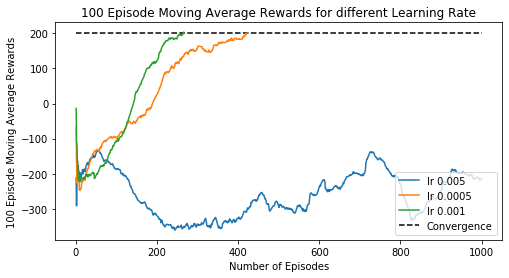

In [23]:
fig= plt.figure(figsize=(8,4))
plt.title('100 Episode Moving Average Rewards for different Learning Rate')
plt.plot([i+1 for i in range(0, len(agent1_lr_trial_score))],agent1_lr_trial_score,label='lr 0.005',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent2_lr_trial_score))],agent2_lr_trial_score,label='lr 0.0005',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent2_trial_score))],agent2_trial_score,label='lr 0.001',alpha=1 )
#plt.plot([i+1 for i in range(0, len(agent4_lr_exp_trial_score))],agent4_lr_exp_trial_score,label='lr 0.0009',alpha=1 )
#plt.plot([i+1 for i in range(0, len(agent2_lr_exp_trial_score))],agent2_lr_exp_trial_score,label='lr 0.0005',alpha=1 )
plt.hlines(200, 0, 1000,colors='k',linestyles='--',label='Convergence')
plt.legend(loc='lower right')
plt.xlabel("Number of Episodes")
plt.ylabel("100 Episode Moving Average Rewards")
plt.show()

## Experiment for Gamma rate ##

### Gamma rate Experiment 1 - lr=0.001, gamma=0.95, epsilon=1, epsilon_decay=0.9, episodes=1000 ###

In [24]:
agent1_gamma_exp = DuellingDQN(env, .001, .95, 1, .9, 1000,256)
agent1_gamma_exp_trial_score=agent1_gamma_exp.train()

episode: 0/1000, score: -323.5970826228678
Average over last 100 episode: -323.60 

episode: 1/1000, score: -220.52842911945544
Average over last 100 episode: -272.06 

episode: 2/1000, score: -85.57887147722346
Average over last 100 episode: -209.90 

episode: 3/1000, score: -233.32502298078748
Average over last 100 episode: -215.76 

episode: 4/1000, score: -199.29219857213204
Average over last 100 episode: -212.46 

episode: 5/1000, score: -110.11056205306333
Average over last 100 episode: -195.41 

episode: 6/1000, score: -420.1098068908821
Average over last 100 episode: -227.51 

episode: 7/1000, score: -68.57568619258728
Average over last 100 episode: -207.64 

episode: 8/1000, score: -146.1257064575386
Average over last 100 episode: -200.80 

episode: 9/1000, score: -217.15742979446543
Average over last 100 episode: -202.44 

episode: 10/1000, score: -275.25058687652637
Average over last 100 episode: -209.06 

episode: 11/1000, score: -420.5523923179659
Average over last 100 epi

episode: 97/1000, score: -171.6678522370344
Average over last 100 episode: -146.46 

episode: 98/1000, score: -93.45664314969267
Average over last 100 episode: -145.93 

episode: 99/1000, score: -77.54592792851501
Average over last 100 episode: -145.25 

episode: 100/1000, score: -59.33733071242325
Average over last 100 episode: -142.60 

episode: 101/1000, score: -132.85227053755892
Average over last 100 episode: -141.73 

episode: 102/1000, score: -80.17930290258637
Average over last 100 episode: -141.67 

episode: 103/1000, score: -69.09371747300656
Average over last 100 episode: -140.03 

episode: 104/1000, score: -59.86287940411377
Average over last 100 episode: -138.64 

episode: 105/1000, score: -73.73784272827454
Average over last 100 episode: -138.27 

episode: 106/1000, score: -27.875181564591028
Average over last 100 episode: -134.35 

episode: 107/1000, score: -65.75601510707665
Average over last 100 episode: -134.32 

episode: 108/1000, score: -60.38971970260147
Average ov

episode: 193/1000, score: -97.84199895417255
Average over last 100 episode: -102.81 

episode: 194/1000, score: -48.96293070950666
Average over last 100 episode: -102.75 

episode: 195/1000, score: -50.775147810021835
Average over last 100 episode: -102.41 

episode: 196/1000, score: -52.830085867973
Average over last 100 episode: -101.77 

episode: 197/1000, score: -75.48064352457304
Average over last 100 episode: -100.81 

episode: 198/1000, score: -54.11854615354987
Average over last 100 episode: -100.41 

episode: 199/1000, score: -57.905271374277945
Average over last 100 episode: -100.22 

episode: 200/1000, score: -97.06015430613961
Average over last 100 episode: -100.60 

episode: 201/1000, score: -319.8091971930828
Average over last 100 episode: -102.46 

episode: 202/1000, score: -64.18476257084075
Average over last 100 episode: -102.30 

episode: 203/1000, score: -6.437448093752616
Average over last 100 episode: -101.68 

episode: 204/1000, score: -69.64318558226628
Average o

episode: 289/1000, score: -254.98507186455754
Average over last 100 episode: -107.75 

episode: 290/1000, score: -158.20851490870444
Average over last 100 episode: -107.55 

episode: 291/1000, score: -312.06384792981714
Average over last 100 episode: -110.32 

episode: 292/1000, score: -138.51651736531295
Average over last 100 episode: -110.54 

episode: 293/1000, score: -83.46471543032273
Average over last 100 episode: -110.39 

episode: 294/1000, score: -187.86532308406444
Average over last 100 episode: -111.78 

episode: 295/1000, score: -270.6825760189219
Average over last 100 episode: -113.98 

episode: 296/1000, score: -273.8368965783576
Average over last 100 episode: -116.19 

episode: 297/1000, score: -32.80328505174687
Average over last 100 episode: -115.76 

episode: 298/1000, score: 20.085931181357353
Average over last 100 episode: -115.02 

episode: 299/1000, score: -130.46954559666398
Average over last 100 episode: -115.75 

episode: 300/1000, score: -304.2389885465756
Ave

episode: 385/1000, score: -49.706083622487355
Average over last 100 episode: -87.95 

episode: 386/1000, score: -49.65684789950195
Average over last 100 episode: -87.26 

episode: 387/1000, score: -202.40851844317734
Average over last 100 episode: -88.09 

episode: 388/1000, score: -36.22292561597849
Average over last 100 episode: -87.56 

episode: 389/1000, score: -41.50991035704188
Average over last 100 episode: -85.42 

episode: 390/1000, score: -32.187496185106276
Average over last 100 episode: -84.16 

episode: 391/1000, score: -31.1609110559045
Average over last 100 episode: -81.35 

episode: 392/1000, score: -28.15511383834845
Average over last 100 episode: -80.25 

episode: 393/1000, score: -104.61416946240472
Average over last 100 episode: -80.46 

episode: 394/1000, score: -184.32536261820297
Average over last 100 episode: -80.43 

episode: 395/1000, score: -95.05701426974686
Average over last 100 episode: -78.67 

episode: 396/1000, score: -83.09231004637729
Average over las

episode: 481/1000, score: -87.69600363788655
Average over last 100 episode: -132.78 

episode: 482/1000, score: -85.08431183969205
Average over last 100 episode: -130.99 

episode: 483/1000, score: -142.6915493796061
Average over last 100 episode: -132.04 

episode: 484/1000, score: -228.8093816241783
Average over last 100 episode: -133.64 

episode: 485/1000, score: -45.205922317809566
Average over last 100 episode: -133.59 

episode: 486/1000, score: -59.563402110325654
Average over last 100 episode: -133.69 

episode: 487/1000, score: -68.12936040738506
Average over last 100 episode: -132.35 

episode: 488/1000, score: -93.55081171232584
Average over last 100 episode: -132.92 

episode: 489/1000, score: -58.06863806703544
Average over last 100 episode: -133.09 

episode: 490/1000, score: -184.35611430440574
Average over last 100 episode: -134.61 

episode: 491/1000, score: -83.52738706746871
Average over last 100 episode: -135.13 

episode: 492/1000, score: -387.428439179639
Average

episode: 576/1000, score: -34.20456973999918
Average over last 100 episode: -93.74 

episode: 577/1000, score: -21.14992416746537
Average over last 100 episode: -90.47 

episode: 578/1000, score: -140.8244087132203
Average over last 100 episode: -89.19 

episode: 579/1000, score: -58.29618298181065
Average over last 100 episode: -86.75 

episode: 580/1000, score: -34.610359497181264
Average over last 100 episode: -84.34 

episode: 581/1000, score: -61.14994797082699
Average over last 100 episode: -84.08 

episode: 582/1000, score: -95.89916779193244
Average over last 100 episode: -84.18 

episode: 583/1000, score: -21.245462816354994
Average over last 100 episode: -82.97 

episode: 584/1000, score: -80.40224895202067
Average over last 100 episode: -81.49 

episode: 585/1000, score: -115.30119451057502
Average over last 100 episode: -82.19 

episode: 586/1000, score: -95.60744943171164
Average over last 100 episode: -82.55 

episode: 587/1000, score: -166.70070433061267
Average over las

episode: 672/1000, score: 236.71097757255086
Average over last 100 episode: -97.31 

episode: 673/1000, score: -13.875306541701447
Average over last 100 episode: -96.43 

episode: 674/1000, score: -77.61736692872178
Average over last 100 episode: -95.49 

episode: 675/1000, score: -186.19902515369483
Average over last 100 episode: -96.76 

episode: 676/1000, score: -70.34362569635378
Average over last 100 episode: -97.12 

episode: 677/1000, score: -116.49728159751479
Average over last 100 episode: -98.08 

episode: 678/1000, score: -437.70591537284923
Average over last 100 episode: -101.04 

episode: 679/1000, score: -266.7445414973118
Average over last 100 episode: -103.13 

episode: 680/1000, score: -240.23141633149578
Average over last 100 episode: -105.19 

episode: 681/1000, score: -43.99776678310563
Average over last 100 episode: -105.01 

episode: 682/1000, score: 201.03966114543704
Average over last 100 episode: -102.04 

episode: 683/1000, score: -300.2908920693774
Average ov

episode: 768/1000, score: -91.79808072611819
Average over last 100 episode: -84.57 

episode: 769/1000, score: -122.42668143865852
Average over last 100 episode: -84.64 

episode: 770/1000, score: -81.7881840707615
Average over last 100 episode: -84.42 

episode: 771/1000, score: -53.51924573058338
Average over last 100 episode: -83.87 

episode: 772/1000, score: -75.75092071708957
Average over last 100 episode: -87.00 

episode: 773/1000, score: -37.50298296881721
Average over last 100 episode: -87.23 

episode: 774/1000, score: -71.685520074407
Average over last 100 episode: -87.17 

episode: 775/1000, score: -364.42371378406585
Average over last 100 episode: -88.96 

episode: 776/1000, score: -403.1525781022508
Average over last 100 episode: -92.29 

episode: 777/1000, score: -262.46411191258716
Average over last 100 episode: -93.74 

episode: 778/1000, score: -288.4780885800431
Average over last 100 episode: -92.25 

episode: 779/1000, score: 86.5019827760498
Average over last 100 

episode: 865/1000, score: -110.8376307746322
Average over last 100 episode: -71.15 

episode: 866/1000, score: -124.9693514468948
Average over last 100 episode: -71.95 

episode: 867/1000, score: -66.91772797029375
Average over last 100 episode: -71.82 

episode: 868/1000, score: -60.3709029245523
Average over last 100 episode: -71.50 

episode: 869/1000, score: -86.7380586845365
Average over last 100 episode: -71.15 

episode: 870/1000, score: -86.4561233102244
Average over last 100 episode: -71.19 

episode: 871/1000, score: -92.65903092518599
Average over last 100 episode: -71.58 

episode: 872/1000, score: -98.11963262892552
Average over last 100 episode: -71.81 

episode: 873/1000, score: -93.30035555184139
Average over last 100 episode: -72.37 

episode: 874/1000, score: -587.4217010562079
Average over last 100 episode: -77.52 

episode: 875/1000, score: -206.0445373017866
Average over last 100 episode: -75.94 

episode: 876/1000, score: -32.2777585464182
Average over last 100 ep

episode: 962/1000, score: -61.50578015896088
Average over last 100 episode: -75.30 

episode: 963/1000, score: -125.26697666761463
Average over last 100 episode: -74.26 

episode: 964/1000, score: -58.275690449811094
Average over last 100 episode: -73.72 

episode: 965/1000, score: -14.736353206920155
Average over last 100 episode: -72.76 

episode: 966/1000, score: -241.39312598009343
Average over last 100 episode: -73.92 

episode: 967/1000, score: -70.52366733099444
Average over last 100 episode: -73.96 

episode: 968/1000, score: -76.43550394468092
Average over last 100 episode: -74.12 

episode: 969/1000, score: -294.4399519354565
Average over last 100 episode: -76.19 

episode: 970/1000, score: -13.294723116407269
Average over last 100 episode: -75.46 

episode: 971/1000, score: -76.68515500122865
Average over last 100 episode: -75.30 

episode: 972/1000, score: -62.12549149994493
Average over last 100 episode: -74.94 

episode: 973/1000, score: -63.425104515597326
Average over l

### Gamma rate Experiment 2 - lr=0.001, gamma=0.99, epsilon=1, epsilon_decay=0.99, episodes=1000 ###

In [26]:
agent2_gamma_exp = DuellingDQN(env, .001, .99, 1, .99, 1000,256)
agent2_gamma_exp_trial_score=agent2_gamma_exp.train()

episode: 0/1000, score: -81.984275621873
Average over last 100 episode: -81.98 

episode: 1/1000, score: -299.38272539187363
Average over last 100 episode: -190.68 

episode: 2/1000, score: -383.7836069522397
Average over last 100 episode: -255.05 

episode: 3/1000, score: -471.9603637211332
Average over last 100 episode: -309.28 

episode: 4/1000, score: -168.7867902901603
Average over last 100 episode: -281.18 

episode: 5/1000, score: -253.42573260478312
Average over last 100 episode: -276.55 

episode: 6/1000, score: -213.2727834785267
Average over last 100 episode: -267.51 

episode: 7/1000, score: -236.47003913153898
Average over last 100 episode: -263.63 

episode: 8/1000, score: -331.8012845659006
Average over last 100 episode: -271.21 

episode: 9/1000, score: -244.01188861343
Average over last 100 episode: -268.49 

episode: 10/1000, score: -207.89046074168792
Average over last 100 episode: -262.98 

episode: 11/1000, score: -277.68017963300883
Average over last 100 episode: 

episode: 97/1000, score: -187.4514661771256
Average over last 100 episode: -116.91 

episode: 98/1000, score: -245.62407888807292
Average over last 100 episode: -118.21 

episode: 99/1000, score: -185.90237500979433
Average over last 100 episode: -118.89 

episode: 100/1000, score: -263.4621231557454
Average over last 100 episode: -120.70 

episode: 101/1000, score: -205.27583717482383
Average over last 100 episode: -119.76 

episode: 102/1000, score: 14.335038199646007
Average over last 100 episode: -115.78 

episode: 103/1000, score: 51.907759274123
Average over last 100 episode: -110.54 

episode: 104/1000, score: -254.47668082146402
Average over last 100 episode: -111.40 

episode: 105/1000, score: -30.458537371225532
Average over last 100 episode: -109.17 

episode: 106/1000, score: -233.12168119502144
Average over last 100 episode: -109.37 

episode: 107/1000, score: -51.57159176277846
Average over last 100 episode: -107.52 

episode: 108/1000, score: 174.42039559051034
Average o

episode: 193/1000, score: -162.47259707300194
Average over last 100 episode: -166.37 

episode: 194/1000, score: -32.55726047272211
Average over last 100 episode: -166.78 

episode: 195/1000, score: -249.480780290389
Average over last 100 episode: -164.17 

episode: 196/1000, score: -74.46291530999223
Average over last 100 episode: -163.54 

episode: 197/1000, score: -81.43415865171977
Average over last 100 episode: -162.48 

episode: 198/1000, score: 255.44870743965416
Average over last 100 episode: -157.47 

episode: 199/1000, score: 272.24038704761006
Average over last 100 episode: -152.89 

episode: 200/1000, score: -223.6011548051519
Average over last 100 episode: -152.49 

episode: 201/1000, score: 198.65289574684965
Average over last 100 episode: -148.45 

episode: 202/1000, score: -179.8303392142676
Average over last 100 episode: -150.39 

episode: 203/1000, score: 213.9075899899501
Average over last 100 episode: -148.77 

episode: 204/1000, score: -97.851468322082
Average over

episode: 289/1000, score: -191.48781777180986
Average over last 100 episode: -83.27 

episode: 290/1000, score: -321.9875178122779
Average over last 100 episode: -82.37 

episode: 291/1000, score: -287.9293294263595
Average over last 100 episode: -83.20 

episode: 292/1000, score: -156.2638495049398
Average over last 100 episode: -83.08 

episode: 293/1000, score: -52.83697260302034
Average over last 100 episode: -81.98 

episode: 294/1000, score: -133.08179277801702
Average over last 100 episode: -82.98 

episode: 295/1000, score: -475.51814927770795
Average over last 100 episode: -85.25 

episode: 296/1000, score: -333.6536457651717
Average over last 100 episode: -87.84 

episode: 297/1000, score: -167.14888979372802
Average over last 100 episode: -88.69 

episode: 298/1000, score: -266.83429808948324
Average over last 100 episode: -93.92 

episode: 299/1000, score: -116.14434221003197
Average over last 100 episode: -97.80 

episode: 300/1000, score: 37.967846453932786
Average over l

episode: 385/1000, score: -223.82713657187398
Average over last 100 episode: -163.46 

episode: 386/1000, score: -273.42477099690586
Average over last 100 episode: -166.00 

episode: 387/1000, score: -412.695566605795
Average over last 100 episode: -165.80 

episode: 388/1000, score: -201.55450373028384
Average over last 100 episode: -165.33 

episode: 389/1000, score: -604.4883605679183
Average over last 100 episode: -169.46 

episode: 390/1000, score: -108.42887320877331
Average over last 100 episode: -167.32 

episode: 391/1000, score: 5.006894863510567
Average over last 100 episode: -164.39 

episode: 392/1000, score: 4.475653426596622
Average over last 100 episode: -162.79 

episode: 393/1000, score: -270.13861783163577
Average over last 100 episode: -164.96 

episode: 394/1000, score: -195.4406358285211
Average over last 100 episode: -165.58 

episode: 395/1000, score: 47.883549463975555
Average over last 100 episode: -160.35 

episode: 396/1000, score: 140.7193810903878
Average 

episode: 481/1000, score: -58.90731398911873
Average over last 100 episode: -63.02 

episode: 482/1000, score: -221.64100641712724
Average over last 100 episode: -64.21 

episode: 483/1000, score: -2.346875324755146
Average over last 100 episode: -63.89 

episode: 484/1000, score: -107.86439323525417
Average over last 100 episode: -63.94 

episode: 485/1000, score: -338.7590576378203
Average over last 100 episode: -65.09 

episode: 486/1000, score: -545.4390747965988
Average over last 100 episode: -67.81 

episode: 487/1000, score: -406.95231515159287
Average over last 100 episode: -67.76 

episode: 488/1000, score: -543.6622541601241
Average over last 100 episode: -71.18 

episode: 489/1000, score: -402.46626575755124
Average over last 100 episode: -69.16 

episode: 490/1000, score: -456.58428554438456
Average over last 100 episode: -72.64 

episode: 491/1000, score: -716.7199858599158
Average over last 100 episode: -79.86 

episode: 492/1000, score: -855.6867709653868
Average over la

episode: 577/1000, score: -68.5968738331646
Average over last 100 episode: -560.82 

episode: 578/1000, score: -24.10277497159322
Average over last 100 episode: -562.68 

episode: 579/1000, score: -196.95960639465673
Average over last 100 episode: -562.68 

episode: 580/1000, score: -620.0724390325115
Average over last 100 episode: -571.59 

episode: 581/1000, score: -116.26489589823018
Average over last 100 episode: -572.16 

episode: 582/1000, score: -330.9729300850163
Average over last 100 episode: -573.26 

episode: 583/1000, score: -126.08446733257767
Average over last 100 episode: -574.49 

episode: 584/1000, score: -207.46230676318154
Average over last 100 episode: -575.49 

episode: 585/1000, score: -61.19597582374706
Average over last 100 episode: -572.71 

episode: 586/1000, score: -40.56293459209837
Average over last 100 episode: -567.66 

episode: 587/1000, score: -331.2296172633289
Average over last 100 episode: -566.91 

episode: 588/1000, score: 145.54896411644586
Averag

episode: 672/1000, score: -234.25831405630072
Average over last 100 episode: -165.75 

episode: 673/1000, score: 7.850760935487983
Average over last 100 episode: -160.62 

episode: 674/1000, score: -0.563504828186389
Average over last 100 episode: -157.92 

episode: 675/1000, score: -176.69006820364328
Average over last 100 episode: -158.78 

episode: 676/1000, score: -291.69216568244593
Average over last 100 episode: -160.42 

episode: 677/1000, score: 215.66726788825594
Average over last 100 episode: -157.57 

episode: 678/1000, score: -306.74420597355186
Average over last 100 episode: -160.40 

episode: 679/1000, score: 22.272235189103643
Average over last 100 episode: -158.21 

episode: 680/1000, score: -154.55797077168347
Average over last 100 episode: -153.55 

episode: 681/1000, score: -17.73236164074372
Average over last 100 episode: -152.57 

episode: 682/1000, score: 53.5278376919872
Average over last 100 episode: -148.72 

episode: 683/1000, score: -138.49442337689646
Averag

episode: 767/1000, score: -543.8660853324964
Average over last 100 episode: -505.08 

episode: 768/1000, score: -421.5159448278859
Average over last 100 episode: -506.07 

episode: 769/1000, score: -143.60108182961582
Average over last 100 episode: -503.75 

episode: 770/1000, score: -260.4322320197053
Average over last 100 episode: -502.33 

episode: 771/1000, score: -556.1965786014666
Average over last 100 episode: -503.69 

episode: 772/1000, score: -942.1478208692305
Average over last 100 episode: -510.77 

episode: 773/1000, score: -259.87070401325303
Average over last 100 episode: -513.45 

episode: 774/1000, score: -240.3958787371976
Average over last 100 episode: -515.84 

episode: 775/1000, score: -1040.4196276094224
Average over last 100 episode: -524.48 

episode: 776/1000, score: -857.4073061819785
Average over last 100 episode: -530.14 

episode: 777/1000, score: -1155.3634465386574
Average over last 100 episode: -543.85 

episode: 778/1000, score: -1139.9309962073378
Aver

episode: 862/1000, score: -174.36260825022833
Average over last 100 episode: -669.48 

episode: 863/1000, score: -20.054337377266833
Average over last 100 episode: -654.72 

episode: 864/1000, score: -222.8923294565391
Average over last 100 episode: -653.94 

episode: 865/1000, score: -95.45755083809429
Average over last 100 episode: -652.55 

episode: 866/1000, score: -121.80672347041403
Average over last 100 episode: -648.97 

episode: 867/1000, score: -630.5682818451467
Average over last 100 episode: -649.84 

episode: 868/1000, score: -122.02263819132028
Average over last 100 episode: -646.85 

episode: 869/1000, score: -71.2211788462666
Average over last 100 episode: -646.12 

episode: 870/1000, score: -340.02507860038025
Average over last 100 episode: -646.92 

episode: 871/1000, score: -724.8317476229711
Average over last 100 episode: -648.60 

episode: 872/1000, score: -2477.942750017638
Average over last 100 episode: -663.96 

episode: 873/1000, score: -409.77397010163537
Aver

episode: 957/1000, score: -161.88351207403636
Average over last 100 episode: -575.63 

episode: 958/1000, score: -183.12390867931543
Average over last 100 episode: -576.91 

episode: 959/1000, score: -48.72075705492481
Average over last 100 episode: -573.17 

episode: 960/1000, score: -114.62892008747801
Average over last 100 episode: -571.73 

episode: 961/1000, score: -333.65017475834543
Average over last 100 episode: -574.51 

episode: 962/1000, score: -963.587802465457
Average over last 100 episode: -582.40 

episode: 963/1000, score: -326.65324333568753
Average over last 100 episode: -585.47 

episode: 964/1000, score: -193.34470740028104
Average over last 100 episode: -585.17 

episode: 965/1000, score: -481.3002135977245
Average over last 100 episode: -589.03 

episode: 966/1000, score: -315.56528043688377
Average over last 100 episode: -590.97 

episode: 967/1000, score: -410.42729805646684
Average over last 100 episode: -588.77 

episode: 968/1000, score: -44.73540418896677
Av

### Plotting 100 Episode Moving Average Rewards for different Gamma rate ###

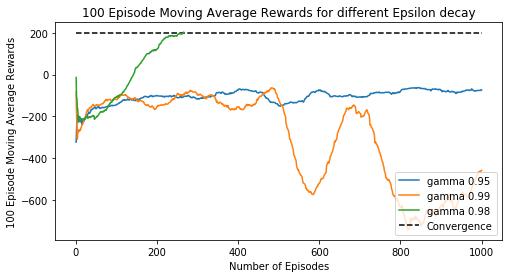

In [30]:
fig= plt.figure(figsize=(8,4))
plt.title('100 Episode Moving Average Rewards for different Epsilon decay')
plt.plot([i+1 for i in range(0, len(agent1_gamma_exp_trial_score))],agent1_gamma_exp_trial_score,label='gamma 0.95',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent2_gamma_exp_trial_score))],agent2_gamma_exp_trial_score,label='gamma 0.99',alpha=1 )
#plt.plot([i+1 for i in range(0, len(agent3_gamma_exp_trial_score))],agent3_gamma_exp_trial_score,label='eps decay 0.8',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent2_trial_score))],agent2_trial_score,label='gamma 0.98',alpha=1 )
#plt.plot([i+1 for i in range(0, len(agent5_epsdecay_exp_trial_score))],agent5_epsdecay_exp_trial_score,label='eps decay 0.5',alpha=1 )
plt.hlines(200, 0, 1000,colors='k',linestyles='--',label='Convergence')
plt.legend(loc='lower right')
plt.xlabel("Number of Episodes")
plt.ylabel("100 Episode Moving Average Rewards")
plt.show()